# Problem set 3: DQN, Policy gradient and its variants

**Due: 11:59pm, November 2, 2025**

In the last PSET of reinforcement learning, you will implement the DQN algorithm together with vanilla policy gradient (REINFORCE) and its variants. In the last problem you will train a half-cheetah with stable baseline 3 package. 

- Problem 1 requires implementing DQN and double DQN. **TODOs:**
  
  - 1.1 Finish vanilla DQN (20 pt)
  - 1.2 Finish double DQN (5 pt)

- Problem 2 verify the policy gradient theory and requires implementing REINFORCE with learned value function. **TODOs:**
  
  - 2.1 Verify different policy gradient estimator (15 pt)
  - 2.2 Implement REINFORCE with learned baseline (10 pt)

- Problem 3 requires implementing vanilla on-policy actor-critic algorithm. **TODOs:**
  - 3.1 Implement vanilla actor-critic (25 pt)

All of these three algorithms works on `gym`'s `Acrobot-v1` environments.

- Problem 4 requires implementing PPO algorithm. **TODOs:**
  - 4.1 Implement PPO-cliping (25 pt)

- Problem 5 **(Bonus)** help you try stable baseline 3 on `gym`'s `Half-cheetah-v4` environment. **TODOs:**
  - 5.1 Tune the parameter in stable baseline 3 (**Note the training can take 15 min**) (20 pt)
  

## Problem 1: DQN

In this problem you will implement DQN on `Acrobot-v1` environment using `gym`.

### Algorithm recap

1. **Q-network**
   - Function approximator $Q_\theta(s,a)$ for action values (here: a small MLP).

2. **Target network**
   - A copy of the online network with parameters $\theta^-$ that are updates periodically to stabilize training.

3. **Experience replay**
   - A replay buffer of transitions $(s,a,r,s',\text{done})$. Sample i.i.d. minibatches to break temporal correlations.

4. **Behavior policy**
   - $\epsilon$-greedy: with probability $\epsilon$ choose a random action; otherwise choose $ \arg\max_a Q_\theta(s,a) $.

5. **TD targets**
   - **Standard DQN**:
     $$
     y = r + \gamma \max_{a'} Q_{\theta^-}(s', a')
     $$
   - **Double DQN**:
     $$
     a^\star = \arg\max_{a'} Q_{\theta}(s', a'), \quad
     y = r + \gamma \, Q_{\theta^-}(s', a^\star)
     $$
     “Online net selects, target net evaluates” reduces overestimation. In comparison to Double Q-learning, the weights of the second network $\theta$ are replaced with the weights of the target network $\theta^−$ for the evaluation of the current greedy policy. The update to the target network stays unchanged from DQN, and remains a periodic copy of the online network.

6. **Loss & optimization**
   - Regress $Q_\theta(s,a)$ to target $y$ using MSE loss; backpropagate to update $\theta$.

### Environment & action space

- **Env**: `Acrobot-v1` (double pendulum swing-up) [Link](https://gymnasium.farama.org/environments/classic_control/acrobot/)
- **Observation**: 6D —- $\cos\theta_1, \sin\theta_1, \cos\theta_2, \sin\theta_2, \dot\theta_1, \dot\theta_2$  
- **Actions**: Discrete 3 actions —- torques $-1, 0, +1$  
- **Reward**: $-1$ per step until the goal is reached (or the episode times out)


### 1.1 Implement DQN with gym

**TODO:** Fill in the three TODO blocks.
- implement a simple MLP
- implement the replaybuffer class
- implement the main algorithm

All the given code is for reference. If you find it inconvenient feel free to write yourself.

Note the final average return should be around $-100$.

[Env] Acrobot-v1 | obs_dim=6, n_actions=3
Ep  10 | Return: -500.0 | Avg: -500.0
Ep  20 | Return: -500.0 | Avg: -490.9
Ep  30 | Return: -500.0 | Avg: -500.0
Ep  40 | Return: -419.0 | Avg: -460.7
Ep  50 | Return: -440.0 | Avg: -468.0
Ep  60 | Return: -411.0 | Avg: -463.3
Ep  70 | Return: -429.0 | Avg: -446.1
Ep  80 | Return: -500.0 | Avg: -411.8
Ep  90 | Return: -356.0 | Avg: -391.1
Ep 100 | Return: -344.0 | Avg: -369.6
Ep 110 | Return: -263.0 | Avg: -251.5
Ep 120 | Return: -396.0 | Avg: -330.4
Ep 130 | Return: -362.0 | Avg: -275.9
Ep 140 | Return: -270.0 | Avg: -277.2
Ep 150 | Return: -377.0 | Avg: -270.4
Ep 160 | Return: -272.0 | Avg: -249.6
Ep 170 | Return: -260.0 | Avg: -221.4
Ep 180 | Return: -279.0 | Avg: -252.1
Ep 190 | Return: -247.0 | Avg: -209.9
Ep 200 | Return: -201.0 | Avg: -177.4
Ep 210 | Return: -189.0 | Avg: -177.4
Ep 220 | Return: -189.0 | Avg: -184.2
Ep 230 | Return: -231.0 | Avg: -178.8
Ep 240 | Return: -242.0 | Avg: -187.1
Ep 250 | Return: -169.0 | Avg: -169.5
Ep 260 |

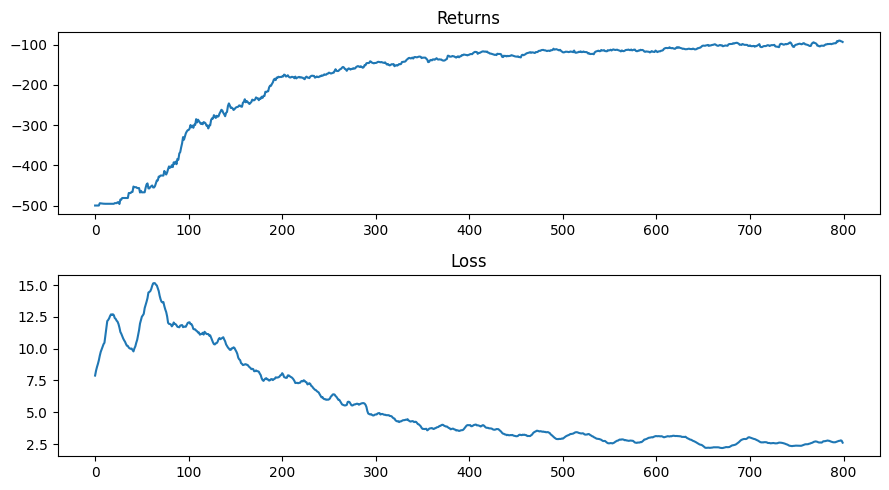

In [ ]:

import os, random
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
import copy

# ------------------- config  -------------------
ENV_ID                 = "Acrobot-v1"
SEED                   = 42
GAMMA                  = 0.995
LR                     = 1e-3
BATCH_SIZE             = 64
BUFFER_SIZE            = 100_000
START_TRAINING_AFTER   = 1000       # warmup steps
TARGET_UPDATE_FREQ     = 10       # steps (hard update)
MAX_EPISODES           = 800

GRAD_CLIP_NORM         = 10.0
PRINT_EVERY_EPISODES   = 10

# ------------------- env & seeding -------------------
env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

state_dims = int(np.prod(env.observation_space.shape))  # Acrobot: 6
num_actions = env.action_space.n                        # Acrobot: 3
print(f"[Env] {ENV_ID} | obs_dim={state_dims}, n_actions={num_actions}")

# ------------------- gym environment -> tensor -------------------
class TWrapper(gym.Wrapper):
    def __init__(self, env): super().__init__(env)
    def reset(self, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        return torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0), info
    def step(self, action):
        a = int(action.item()) if isinstance(action, torch.Tensor) else int(action)
        obs, r, term, trunc, info = self.env.step(a)
        done = bool(term or trunc)
        obs_t = torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0)
        r_t   = torch.tensor([[r]], dtype=torch.float32)
        d_t   = torch.tensor([[done]], dtype=torch.bool)
        return obs_t, r_t, d_t, info

env = TWrapper(env)

# ------------------- Q network -------------------
class QNetwork(nn.Module):
    #########################################
    #TODO 1.1: Implement a simple MLP
    #########################################
    def __init__(self, obs_dim, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
    
    def forward(self, x):
        return self.net(x)

q_net = QNetwork(state_dims, num_actions)
tgt_net = copy.deepcopy(q_net).eval()

# ------------------- simple replay buffer -------------------
class ReplayBuffer:
    def __init__(self, capacity=BUFFER_SIZE):
        self.capacity, self.mem, self.pos = capacity, [], 0
    #########################################
    #TODO 1.1: Implement a ReplayBuffer
    # capacity: max number of transitions to store
    # mem: list of transitions
    # pos: next position to insert
    # push: add a transition
    # sample: random sample a batch of transitions
    #########################################
    def push(self, transition):
        if len(self.mem) < self.capacity:
            self.mem.append(transition)
        else:
            self.mem[self.pos] = transition
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size):
        return random.sample(self.mem, batch_size)
    
buffer = ReplayBuffer()
optim  = Adam(q_net.parameters(), lr=LR)

# ------------------- greedy / epsilon-greedy -------------------
@torch.no_grad()
def act_epsilon_greedy(state: torch.Tensor, eps: float) -> torch.Tensor:
    if torch.rand(1).item() < eps:
        return torch.randint(num_actions, (1, 1))
    q = q_net(state)
    return torch.argmax(q, dim=-1, keepdim=True)

# ------------------- train loop (Double DQN target) -------------------
def train():
    returns_hist, loss_hist = [], []
    global_step = 0

    for ep in range(1, MAX_EPISODES + 1):
        #########################################
        #TODO 1.1: Implement the main algorithm here
        #########################################
        state, _ = env.reset()
        ep_return, ep_loss = 0.0, []
        done = False
        
        while not done:
            # Epsilon decay: linear from 1.0 to 0.01
            eps = max(0.01, 1.0 - 0.99 * global_step / (MAX_EPISODES * 200))
            
            # Select action
            action = act_epsilon_greedy(state, eps)
            
            # Step environment
            next_state, reward, done_t, _ = env.step(action)
            done = done_t.item()
            
            # Store transition
            buffer.push((state, action, reward, next_state, done_t))
            
            state = next_state
            ep_return += reward.item()
            global_step += 1
            
            # Train if buffer has enough samples
            if len(buffer.mem) >= START_TRAINING_AFTER:
                batch = buffer.sample(BATCH_SIZE)
                s_b, a_b, r_b, ns_b, d_b = zip(*batch)
                
                s_b = torch.cat(s_b)
                a_b = torch.cat(a_b)
                r_b = torch.cat(r_b)
                ns_b = torch.cat(ns_b)
                d_b = torch.cat(d_b)
                
                # Compute Q(s, a)
                q_vals = q_net(s_b).gather(1, a_b)
                
                # Vanilla DQN target:
                # with torch.no_grad():
                #     target_q = tgt_net(ns_b).max(dim=1, keepdim=True)[0]
                #     target = r_b + GAMMA * target_q * (~d_b)
                
                #########################################
                #TODO 1.2: Change from DQN to Double DQN
                #########################################
                # Double DQN: online net selects, target net evaluates
                with torch.no_grad():
                    best_actions = q_net(ns_b).argmax(dim=1, keepdim=True)
                    target_q = tgt_net(ns_b).gather(1, best_actions)
                    target = r_b + GAMMA * target_q * (~d_b)
                
                # Loss and optimization
                loss = F.mse_loss(q_vals, target)
                optim.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(q_net.parameters(), GRAD_CLIP_NORM)
                optim.step()
                
                ep_loss.append(loss.item())
            
            # Update target network
            if global_step % TARGET_UPDATE_FREQ == 0:
                tgt_net.load_state_dict(q_net.state_dict())
        
        returns_hist.append(ep_return)
        loss_hist.append(np.mean(ep_loss) if ep_loss else 0.0)
        
        if ep % PRINT_EVERY_EPISODES == 0:
            avg_return = np.mean(returns_hist[-PRINT_EVERY_EPISODES:])
            print(f"Ep {ep:3d} | Return: {ep_return:6.1f} | Avg: {avg_return:6.1f}")
        #########################################
        #TODO 1.2: Change from DQN to Double DQN
        #########################################
        
    plot_stats({"Returns": returns_hist, "Loss": loss_hist})

# ------------------- plotting -------------------
def _smooth(x, w=21):
    if len(x) < w: return x
    k = w // 2
    return [np.mean(x[max(0, i-k):min(len(x), i+k+1)]) for i in range(len(x))]

def plot_stats(stats: dict, win: int = 21):
    fig, axs = plt.subplots(len(stats), 1, figsize=(9, 5), tight_layout=True)
    if len(stats) == 1: axs = [axs]
    for ax, (k, v) in zip(axs, stats.items()):
        ax.plot(_smooth(v, win))
        ax.set_title(k)
    plt.show()
    plt.close()

train()
env.close()


### 1.2 Change classical DQN to double DQN

Use **two networks**:
- **Online** network selects the next action  
  $$
  a^* = \arg\max_{a'} Q_{\text{online}}(s', a').
  $$
- **Target** network evaluates that action  
  $$
  y_{\text{DDQN}} = r + \gamma\, Q_{\text{target}}(s', a^*).
  $$
  
This decoupling reduces overestimation while keeping the update otherwise unchanged.

In the code you will only need to change several lines. 

**TODO:** Comment the vanilla DQN and write Double DQN at the same place.

## Problem 2: Policy Gradient

<!-- #### reparameterization trick:

Let $x$ be a random variable whose distribution depends on $\theta$. Write this as $x\sim p_\theta(x)$. For any measurable $V:\mathcal X\to\mathbb R$,
$$
\mathbb{E}\big[V(f(\theta))\big] \;=\; \mathbb{E}_{x\sim p_\theta}[V(x)],
$$
where $p_\theta$ is the distribution of $x$ induced by $\theta$. This help us move complex functions from expectation to distribution.

Take the gradient gives us

$$
\nabla \mathbb{E}_{x\sim p_\theta}[V(x)] = \int \nabla p_\theta(x) V(x) dx = \int \nabla \ln(p_\theta(x)) V(x) p_\theta(x)dx = \mathbb{E}_{x\sim p_\theta}[V(x) \nabla \ln(p_\theta(x))]
$$

So now we only need to take derivative of the distribution.

### RL as an Expectation over Trajectories
The cost over a distribution of $s_0$ gives the definition of reward function $J$:

$$
\mathbb{E}_{s_0\sim\rho}[V^{\pi_\theta}(s_0)]
$$

But use the trick above we can rewrite that using trajectory. A trajectory is
$$
\tau=(s_0,a_0,s_1,a_1,\ldots,s_T),
$$
generated by initial state distribution $\rho$, policy $\pi_\theta(a\mid s)$, and dynamics $P(s'\mid s,a)$. The trajectory distribution is
$$
p_\theta(\tau)=\rho(s_0)\prod_{t=0}^{T-1}\pi_\theta(a_t\mid s_t)\,P(s_{t+1}\mid s_t,a_t).
$$
Define the discounted return
$$
G(\tau)=\sum_{t=0}^{T-1}\gamma^t\,r(s_t,a_t).
$$
Then the performance objective is
$$
\,J(\theta)=\mathbb{E}_{\tau\sim p_\theta}[G(\tau)]\,
$$

This helps move the $\theta$ to distribution.
 -->

### Recall: Policy-Gradient Theorem

$$
\begin{aligned}
\nabla_\theta J(\theta)
&= \nabla_\theta \mathbb{E}_{\tau\sim p_\theta}[G(\tau)]
= \mathbb{E}_{\tau\sim p_\theta}\!\left[G(\tau)\,\nabla_\theta\log p_\theta(\tau)\right] \\
&= \mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(a_t\mid s_t)\,G(\tau)\right] \\
\end{aligned} \tag{F1}
$$

This is the first gradient formulation we arrive at (here $G(\tau) = R(\tau)$ and $R(\tau)$ is the notation used in Lecture notes). A naive collary is the using causality to change that to return-to-go:

$$
\begin{aligned}
\nabla_\theta J(\theta)
&= \mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,G_t(\tau)\right]
\end{aligned} \tag{F2} 
$$

where $G_t=\sum_{k=t}^{T-1}\gamma^{k-t}r(s_k,a_k)$ and $d^{\pi_\theta}$ is the discounted state-visitation distribution. Next, we observe that 

$$
\mathbb{E}_{a_t\sim\pi_\theta}\!\left[\nabla_\theta\log\pi_\theta(a_t\mid s_t)\,b(s_t)\right]=0,
$$

<!-- This is because condition on $s_t$, $b(s_t)$ is a constant inside expectation, and $\mathbb{E}_{a_t\sim\pi_\theta}\!\left[\nabla_\theta\log\pi_\theta(a_t\mid s_t)\right]=0$.  -->

Plug in the "baseline" $b(s_t)$ into the policy gradient gives us

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,(G_t(\tau)- b(s_t))\right] \tag{F3}
$$

In practice most of the time people use the learned value function for the baseline.

### Policy gradient theorem (extended)

Next we talk about another 3 chosen of policy gradient:

From (F2) gradient we can easily see that $Q(s_t,a_t) = \mathbb{E}[G_t(\tau)]$, so plug in F2 gives us
$$
\mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,Q(s_t,a_t)\right] \tag{F4}
$$

And followed by previous explanation of baseline, we can define $A(s_t,a_t) = Q(s_t,a_t) - V(s_t)$, thus we arrive the *advantage function* gradient.
$$
\mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,A(s_t,a_t)\right] \tag{F5}
$$

The last formulation is by observing that
$$
\mathbb{E}[Q(s_t,a_t)] = \mathbb{E}[r(s_t,a_t) + \gamma V(s_{t+1})]
$$

apply baseline to it gives us
$$
\mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,(r(s_t,a_t) + \gamma V(s_{t+1}) - V(s_t))\right] \tag{F6}
$$

### 2.1 Convergence of Different Policy-Gradient Estimators

We study a random walk on a ring. Let $\mathcal{S}=\mathbb{Z}_N$ and $\mathcal{A}=\{L,R\}$. The dynamics and rewards are
$$
s_{t+1}\equiv s_t+\begin{cases}
+1 & \text{if }a_t = R, \\
-1 & \text{if }a_t = L,
\end{cases}\ (\mathrm{mod}\,N),\qquad
r_t \equiv \begin{cases}
r_\text{terminal} & \text{if done} \\
r_\text{step} & \text{otherwise}
\end{cases},\quad \gamma\in(0,1).
$$

Because this is tabular, Bellman consistency (Eq. 1.21) yields a linear system $AV=b$ (as in PSET1, Problem 4). Solving gives the exact values $V$, and $Q$ follows by one-step lookahead.

**TODO:**
1. Implement a minimal MLP policy ($x=s/N\to\pi_\theta(\cdot\mid s)$) with a Softmax output.  
2. Implement six MC gradient estimators: REINFORCE, return-to-go, baseline with $V$, using $Q$, advantage $Q{-}V$, and TD-residual.  
3. Plot per-parameter sample std and the running-mean error $\|\bar g_k-\nabla_\theta J\|_2$ vs. episodes, plus $|\bar J_k-J_{\text{true}}|$.
   $$\bar g_k = \frac{1}{k} \sum_i^k g_i, \quad \bar J_k = \frac{1}{k} \sum_i^k J_i$$
   
4. Comment on what you see, and explain it intuitively.

Note:

Here we provide the function `build_system`, `get_V_and_J` and `get_Q` for calculate the true value / action value. `finite_difference_grad` for approximate the true objective / gradient by finite difference. And also `logp_single` and `score_matrix_batch` for calculate $\nabla J_\theta$ in a batched manner (You can also use for-loop, but that takes quite long run time). But feel free to use your own code.


Standard deviations of gradient estimators:
  g1 (full-return):    22.7905
  g2 (return-to-go):   10.6143
  g3 (baseline V):     15.9315
  g4 (Q):              25.1998
  g5 (advantage Q-V):  18.1273
  g6 (TD residual):    18.1273

True J: 36.4308


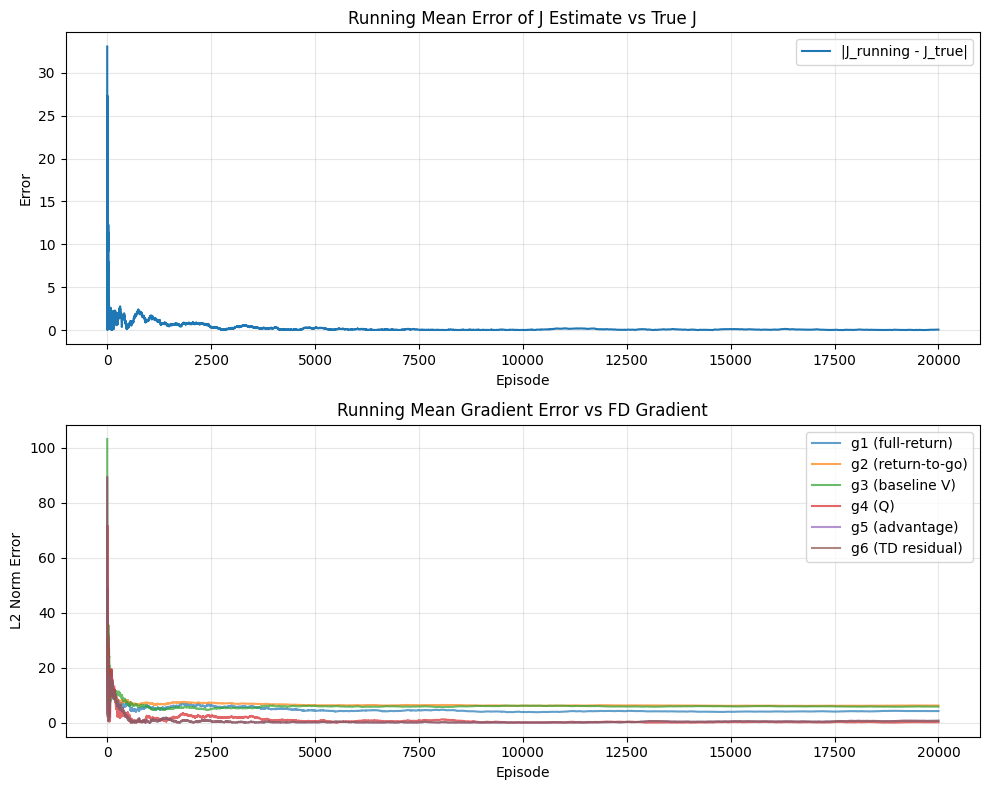

In [ ]:
import math, random
from typing import Tuple, List
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import matplotlib.pyplot as plt
from torch.func import functional_call, vmap, jacrev


# ----------------- utilities -----------------
def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# ----------------- policy network (last layer Softmax) -----------------
class PolicyNet(nn.Module):
    #########################################
    #TODO 2.1: Implement the policy network
    #########################################
    def __init__(self, hidden=2):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden)
        self.fc2 = nn.Linear(hidden, 2)
    
    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(1)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=-1)

# ----------------- DP: exact J(θ) using policy p_s -----------------
def build_system(model: PolicyNet, N: int, gamma: float,
                 running_reward: float, terminal_reward: float):
    """
    In tabular case, we could build A,b directly from the bellman's equations (eq 1.21 in lecture note).
    Build linear system A V = b for states s=1..N-1.
    Transition probabilities p_s come from the torch policy (Right prob).
    """
    model.eval()
    with torch.no_grad():
        s_idx = torch.arange(1, N, dtype=torch.float32)
        x = s_idx / float(N)                  # (N-1,)
        pi = model(x)                         # (N-1, 2)
        p = pi[:, 1].cpu().numpy()            # P(right | s)
        q = (1.0 - p)                         # P(left  | s)

    A = np.zeros((N-1, N-1), dtype=np.float64)
    b = np.zeros(N-1, dtype=np.float64)

    if N - 1 == 1:
        A[0, 0] = 1.0
        b[0] = terminal_reward
        return A, b

    # s = 1 (index 0)
    A[0, 0] = 1.0
    A[0, 1] = -gamma * p[0]
    b[0] = q[0] * terminal_reward + p[0] * running_reward

    # s = 2..N-2 (indices 1..N-3)
    for s in range(2, N-1):
        i = s - 1
        A[i, i]   = 1.0
        A[i, i-1] = -gamma * q[i]
        A[i, i+1] = -gamma * p[i]
        b[i]      = running_reward

    # s = N-1 (index N-2)
    i = N - 2
    A[i, i]   = 1.0
    A[i, i-1] = -gamma * q[i]
    b[i]      = p[i] * terminal_reward + q[i] * running_reward
    return A, b

def get_V_and_J(model: PolicyNet, N: int, gamma: float,
                running_reward: float, terminal_reward: float):
    """Solve A V = b; return V(s) for s=1..N-1 and uniform-start J."""
    A, b = build_system(model, N, gamma, running_reward, terminal_reward)
    V = np.linalg.solve(A, b)
    return V, float(V.mean())

def get_Q(model: PolicyNet, N: int, gamma: float,
          running_reward: float, terminal_reward: float):
    """
    Q(s,a) via one-step lookahead using V from DP.
    Returns Q for s=1..N-1 (shape (N-1, 2)).
    """
    V, _ = get_V_and_J(model, N, gamma, running_reward, terminal_reward)
    V_full = np.zeros(N + 1)
    V_full[1:N] = V
    s = np.arange(1, N, dtype=np.int64)
    sL, sR = s - 1, s + 1
    rL = np.where(sL == 0, terminal_reward, running_reward)
    rR = np.where(sR == N, terminal_reward, running_reward)
    Q = np.empty((N-1, 2), dtype=np.float64)
    Q[:, 0] = rL + gamma * V_full[sL]
    Q[:, 1] = rR + gamma * V_full[sR]
    return Q

# ----------------- Finite-difference gradient on θ (torch) -----------------
def finite_difference_grad(model: PolicyNet, N: int, gamma: float,
                           running_reward: float, terminal_reward: float,
                           eps: float = 1e-4, relative: bool = False,
                           scheme: str = 'central'):
    """
    Finite-difference ∇θ J where θ is the concatenated torch parameter vector.
    Supports central or forward difference. Optional relative step size.
    """
    theta0 = parameters_to_vector(model.parameters()).detach().clone()
    _, J0 = get_V_and_J(model, N, gamma, running_reward, terminal_reward)
    grad = torch.zeros_like(theta0)

    for i in range(theta0.numel()):
        base = float(abs(theta0[i])) if relative else 1.0
        h = eps * max(1.0, base)

        if scheme.lower() == 'central':
            th_p = theta0.clone(); th_p[i] += h
            th_m = theta0.clone(); th_m[i] -= h
            vector_to_parameters(th_p, model.parameters())
            Jp = get_V_and_J(model, N, gamma, running_reward, terminal_reward)[1]
            vector_to_parameters(th_m, model.parameters())
            Jm = get_V_and_J(model, N, gamma, running_reward, terminal_reward)[1]
            grad[i] = (Jp - Jm) / (2.0 * h)
        elif scheme.lower() == 'forward':
            th_p = theta0.clone(); th_p[i] += h
            vector_to_parameters(th_p, model.parameters())
            Jp = get_V_and_J(model, N, gamma, running_reward, terminal_reward)[1]
            grad[i] = (Jp - J0) / h
        else:
            raise ValueError("scheme must be 'central' or 'forward'")

    # restore original params
    vector_to_parameters(theta0, model.parameters())
    return J0, grad.detach()

# ----------------- MC gradient estimators (REINFORCE family) -----------------
def mc_grad_estimators(model: PolicyNet, N: int, s0_batch: torch.Tensor, gamma: float,
                       step_cost: float, terminal_reward: float,
                       V: torch.Tensor = None, Q: torch.Tensor = None):
    """
    We compute per-sample score vectors using autograd by calling backward()
    on log π(a_t|s_t) to obtain ∇θ log π(a_t|s_t).

    Returns (all numpy arrays):
      g1..g6: (B, P) per-episode gradient samples; J: (B,)
        g1: full-return REINFORCE
        g2: return-to-go REINFORCE (via cumulative scores H)
        g3: baseline with V(s_t)
        g4: use Q(s_t, a_t)
        g5: use Advantage A = Q − V
        g6: use TD residual δ_t = r_t + γ V(s_{t+1}) − V(s_t)
    """
    device = next(model.parameters()).device
    model.eval()
    
    names, base_params = zip(*list(model.named_parameters()))
    # Detach so these are leaf tensors, then turn grad on (required by jacrev)
    params = tuple(p.detach().requires_grad_(True) for p in base_params)
    P = sum(p.numel() for p in params)

    B = int(s0_batch.numel())
    s    = s0_batch.to(device).clone()
    done = (s == 0) | (s == N)

    H  = torch.zeros(B, P, device=device)  # cumulative score per-episode
    g1 = torch.zeros(B, P, device=device)
    g2 = torch.zeros(B, P, device=device)
    g3 = torch.zeros(B, P, device=device)
    g4 = torch.zeros(B, P, device=device)
    g5 = torch.zeros(B, P, device=device)
    g6 = torch.zeros(B, P, device=device)
    J  = torch.zeros(B,   device=device)
    gpw= torch.ones (B,   device=device)  # γ^t

    if V is not None:
        V = V.to(device)     # shape N+1, suggest V[0]=V[N]=0
    if Q is not None:
        Q = Q.to(device)     # shape (N+1,2), with Q(0,.)=Q(N,.)=0 if you padded
    
    def logp_single(param_tensors, s_scalar: torch.Tensor, a_scalar: torch.Tensor):
        # Build a param dict for functional_call
        pmap = {n: t for n, t in zip(names, param_tensors)}
        x = (s_scalar.float() / float(N)).view(1, 1)
        probs = functional_call(model, pmap, (x,))    # (1,2)
        # Differentiable action selection via gather (avoid data-dependent indexing pitfalls)
        logp = probs.log().gather(1, a_scalar.long().view(1, 1)).squeeze()  # scalar
        return logp

    # Note: you may found this function useful, this calculate ∇θ log π(a_i|s_i) in a batch manner
    def score_matrix_batch(active_s: torch.Tensor, active_a: torch.Tensor) -> torch.Tensor:
        """
        Returns (B_act, P) where each row is ∇θ log π(a_i|s_i),
        computed efficiently via vmap(jacrev) over (s,a).
        """
        # jac is a pytree of tensors matching param shapes, each with leading dim B_act
        jac = vmap(jacrev(logp_single), in_dims=(None, 0, 0))(params, active_s, active_a)
        # Flatten each param’s jacobian and concatenate along feature dim
        parts = [g.reshape(g.shape[0], -1) for g in jac]
        return torch.cat(parts, dim=1)  # (B_act, P)


    while not torch.all(done):
        idx = (~done).nonzero(as_tuple=False).squeeze(1)
        if idx.numel() == 0:
            break

        # Sample actions for all active states in one forward pass
        x = (s[idx].float() / float(N)).unsqueeze(1)
        with torch.no_grad():
            probs = model(x)                            # (B_act, 2)
            a = torch.multinomial(probs, 1).squeeze(1) # (B_act,)

        # ∇θ log π(a|s): (B_act, P) using backward()
        score_mat = score_matrix_batch(s[idx], a)

        # Next state, termination, and rewards
        s_next   = s[idx] + torch.where(a == 1, 1, -1)
        term_any = (s_next == 0) | (s_next == N)
        r_t = torch.where(
            term_any,
            torch.tensor(terminal_reward, device=device),
            torch.tensor(step_cost, device=device)
        ).float()
        
        #########################################
        #TODO 2.1: Implement the six policy gradient estimators
        #########################################
        # Accumulate discounted rewards
        J[idx] += gpw[idx].squeeze() * r_t
        
        # Update cumulative score H = sum_t γ^t ∇log π
        H[idx] += gpw[idx].unsqueeze(1) * score_mat
        
        # g1: full-return REINFORCE (update at end with total J)
        # Will be computed: g1 += H * J
        
        # g2: return-to-go REINFORCE
        g2[idx] += gpw[idx].unsqueeze(1) * score_mat * J[idx].unsqueeze(1)
        
        # g3: baseline with V(s_t)
        if V is not None:
            V_s = V[s[idx]].unsqueeze(1)
            g3[idx] += gpw[idx].unsqueeze(1) * score_mat * (J[idx].unsqueeze(1) - V_s)
        
        # g4: use Q(s_t, a_t)
        if Q is not None:
            Q_sa = Q[s[idx], a].unsqueeze(1)
            g4[idx] += gpw[idx].unsqueeze(1) * score_mat * Q_sa
        
        # g5: advantage A = Q - V
        if V is not None and Q is not None:
            V_s = V[s[idx]].unsqueeze(1)
            Q_sa = Q[s[idx], a].unsqueeze(1)
            adv = Q_sa - V_s
            g5[idx] += gpw[idx].unsqueeze(1) * score_mat * adv
        
        # g6: TD residual δ = r + γ V(s') - V(s)
        if V is not None:
            V_s = V[s[idx]].unsqueeze(1)
            V_next = V[s_next].unsqueeze(1)
            td_error = r_t.unsqueeze(1) + gamma * V_next - V_s
            g6[idx] += gpw[idx].unsqueeze(1) * score_mat * td_error
        
        # Update state, done flag, and discount factor
        s[idx] = s_next
        done[idx] = term_any
        gpw[idx] *= gamma
    
    # Finalize g1: full-return REINFORCE
    g1 = H * J.unsqueeze(1)
        
    return (g1.detach().cpu().numpy(),
            g2.detach().cpu().numpy(),
            (g3.detach().cpu().numpy() if V is not None else np.zeros_like(g2.detach().cpu().numpy())),
            (g4.detach().cpu().numpy() if Q is not None else np.zeros_like(g2.detach().cpu().numpy())),
            (g5.detach().cpu().numpy() if (V is not None and Q is not None) else np.zeros_like(g2.detach().cpu().numpy())),
            g6.detach().cpu().numpy() if V is not None else np.zeros_like(g2.detach().cpu().numpy()),
            J.detach().cpu().numpy())

# ----------------- main -----------------
set_seed(0)
device = torch.device("cpu")

# Environment
N = 10
gamma = 0.9
running_reward = -1.0
terminal_reward = 100.0

# Policy
model = PolicyNet(hidden=2).to(device)

# Exact J and FD gradient
J_true, grad_fd = finite_difference_grad(
    model, N, gamma, running_reward, terminal_reward,
    eps=1e-4, relative=True, scheme='central'
)

# Baselines from DP value V(s) and Q(s,a)
V_np, _ = get_V_and_J(model, N, gamma, running_reward, terminal_reward)
V = torch.tensor(np.concatenate(([0.0], V_np, [0.0])), dtype=torch.float32, device=device)  # V(0)=V(N)=0

Q_np = get_Q(model, N, gamma, running_reward, terminal_reward).astype(np.float32)
Q_t  = torch.tensor(Q_np, dtype=torch.float32, device=device)
zero_row = torch.zeros(1, 2, dtype=torch.float32, device=device)
Q = torch.cat([zero_row, Q_t, zero_row], dim=0)  # Q(0,.)=Q(N,.)=0

# Monte Carlo (batched episodes)
episodes = 20000  # adjust as needed
s0_batch = torch.randint(1, N, (episodes,), dtype=torch.int64, device=device)
g1, g2, g3, g4, g5, g6, J = mc_grad_estimators(
    model, N, s0_batch, gamma,
    step_cost=running_reward,
    terminal_reward=terminal_reward,
    V=V, Q=Q
)

#########################################
#TODO 2.1: Plot your result here
# 1. Print out the standard deviation of each gradient estimator
# 2. Plot the running error of the estimated J vs the true J, you may found np.cumsum(:, axis=0) / np.arange(1, len(J) + 1) useful
# 3. Plot the running error of each gradient estimator vs the FD gradient
#########################################

# 1. Print standard deviations
print("Standard deviations of gradient estimators:")
print(f"  g1 (full-return):    {np.std(g1, axis=0).mean():.4f}")
print(f"  g2 (return-to-go):   {np.std(g2, axis=0).mean():.4f}")
print(f"  g3 (baseline V):     {np.std(g3, axis=0).mean():.4f}")
print(f"  g4 (Q):              {np.std(g4, axis=0).mean():.4f}")
print(f"  g5 (advantage Q-V):  {np.std(g5, axis=0).mean():.4f}")
print(f"  g6 (TD residual):    {np.std(g6, axis=0).mean():.4f}")
print(f"\nTrue J: {J_true:.4f}")

# 2. Running mean of J estimate vs true J
J_running = np.cumsum(J) / np.arange(1, len(J) + 1)
J_error = np.abs(J_running - J_true)

# 3. Running mean of gradients vs FD gradient
grad_fd_np = grad_fd.cpu().numpy()
g1_running = np.cumsum(g1, axis=0) / np.arange(1, len(g1) + 1)[:, None]
g2_running = np.cumsum(g2, axis=0) / np.arange(1, len(g2) + 1)[:, None]
g3_running = np.cumsum(g3, axis=0) / np.arange(1, len(g3) + 1)[:, None]
g4_running = np.cumsum(g4, axis=0) / np.arange(1, len(g4) + 1)[:, None]
g5_running = np.cumsum(g5, axis=0) / np.arange(1, len(g5) + 1)[:, None]
g6_running = np.cumsum(g6, axis=0) / np.arange(1, len(g6) + 1)[:, None]

g1_error = np.linalg.norm(g1_running - grad_fd_np, axis=1)
g2_error = np.linalg.norm(g2_running - grad_fd_np, axis=1)
g3_error = np.linalg.norm(g3_running - grad_fd_np, axis=1)
g4_error = np.linalg.norm(g4_running - grad_fd_np, axis=1)
g5_error = np.linalg.norm(g5_running - grad_fd_np, axis=1)
g6_error = np.linalg.norm(g6_running - grad_fd_np, axis=1)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8), tight_layout=True)

# Plot 1: Running J error
axs[0].plot(J_error, label='|J_running - J_true|')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Error')
axs[0].set_title('Running Mean Error of J Estimate vs True J')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Plot 2: Running gradient errors
axs[1].plot(g1_error, label='g1 (full-return)', alpha=0.7)
axs[1].plot(g2_error, label='g2 (return-to-go)', alpha=0.7)
axs[1].plot(g3_error, label='g3 (baseline V)', alpha=0.7)
axs[1].plot(g4_error, label='g4 (Q)', alpha=0.7)
axs[1].plot(g5_error, label='g5 (advantage)', alpha=0.7)
axs[1].plot(g6_error, label='g6 (TD residual)', alpha=0.7)
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('L2 Norm Error')
axs[1].set_title('Running Mean Gradient Error vs FD Gradient')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.show()


# Answer:
From observing the results, we can see that return-to-go has the lowest variance, while Q has the highest variance. We can also see from the plots that all estimators converge to the true gradient, with g2 the fastest, while g1 and g4 are the slowest. The J estimate also converges quickly after only about 2000 episodes. Intuitively, g2 wins because causality matters in that actions at time t cannot affect rewards before t. On the other hand, g1 includes past rewards, which adds noise without information. g2 only uses future rewards, which removes the unnecessary variance. Q-values are also highly variable because even though it's the true expected return, using it raw can be noisy. Q values are large, so small errors lead to a large variance. We need a baseline to center the values. g5 and g6 have about identical variance because they're mathematically equivalent. g3 helps moderately because subtracting the baseline reduces variance, but it doesn't exploit causality like g2. Lower variance leads to faster convergence because fewer samples are needed. Thus, this ranking confirms policy gradient theory, where exploiting causality and using baselines/advantages are crucial for training efficiency.

### 2.2 REINFORCE algorithm

**Algorithm Recap — REINFORCE (Monte-Carlo Policy Gradient)**

1. **Policy network**  
   Stochastic policy $\pi_\theta(a\mid s)$ 

2. **Trajectory sampling**  
   Roll out episodes with $\pi_\theta$: $(s_1,a_1,r_1,\dots,s_T,a_T,r_T)$.

3. **Returns / advantages**
   - Monte-Carlo return:
     $$
     G_t=\sum_{t'=t}^{T}\gamma^{\,t'-t} r_{t'}.
     $$
   - Advantage: $A_t = G_t - b(s_t)$.

4. **Policy-gradient update**
   - Estimator:
     $$
     \hat g(\theta)=\frac{1}{N}\sum_{i=1}^{N}\sum_{t=1}^{T_i}
       \nabla_\theta \log \pi_\theta(a_t^{(i)}\mid s_t^{(i)})\, \gamma^t A_t^{(i)}.
     $$
   - Gradient ascent: $\theta \leftarrow \theta + \alpha\,\hat g(\theta)$.

5. **Learned value baseline (optional)**
   - Regress $V_\psi(s)$ to returns:
     $$
     \min_\psi \frac{1}{N}\sum_{i,t}\big(V_\psi(s_t^{(i)})-G_t^{(i)}\big)^2,
     \qquad A_t\!=\!G_t\!-\!V_\psi(s_t).
     $$

6. **Mini-batch training**
   - Collect $N$ episodes (or $M$ steps), compute $G_t/A_t$; optimize
     $$
     \mathcal{L}_{\text{PG}}(\theta)=
     -\frac{1}{N}\sum_{i,t}\log\pi_\theta(a_t^{(i)}\mid s_t^{(i)})\,A_t^{(i)}.
     $$

**TODO:**
- implement policy net and value net
- implement the main algorithm


Epoch 10/400 | Avg Return: -500.0 | Policy Loss: -91.3395 | Value Loss: 8151.0703
Epoch 20/400 | Avg Return: -500.0 | Policy Loss: 0.5634 | Value Loss: 2510.0891
Epoch 30/400 | Avg Return: -500.0 | Policy Loss: -1.2015 | Value Loss: 2312.8545
Epoch 40/400 | Avg Return: -500.0 | Policy Loss: 1.1968 | Value Loss: 2271.1311
Epoch 50/400 | Avg Return: -500.0 | Policy Loss: 1.8738 | Value Loss: 2418.8191
Epoch 60/400 | Avg Return: -500.0 | Policy Loss: 1.3141 | Value Loss: 2410.0833
Epoch 70/400 | Avg Return: -500.0 | Policy Loss: -2.0358 | Value Loss: 2177.1726
Epoch 80/400 | Avg Return: -500.0 | Policy Loss: 0.9144 | Value Loss: 2153.3213
Epoch 90/400 | Avg Return: -500.0 | Policy Loss: 4.4196 | Value Loss: 2089.1108
Epoch 100/400 | Avg Return: -500.0 | Policy Loss: -4.2780 | Value Loss: 2084.9456
Epoch 110/400 | Avg Return: -500.0 | Policy Loss: 3.6587 | Value Loss: 2014.3209
Epoch 120/400 | Avg Return: -500.0 | Policy Loss: -1.5166 | Value Loss: 2152.8293
Epoch 130/400 | Avg Return: -50

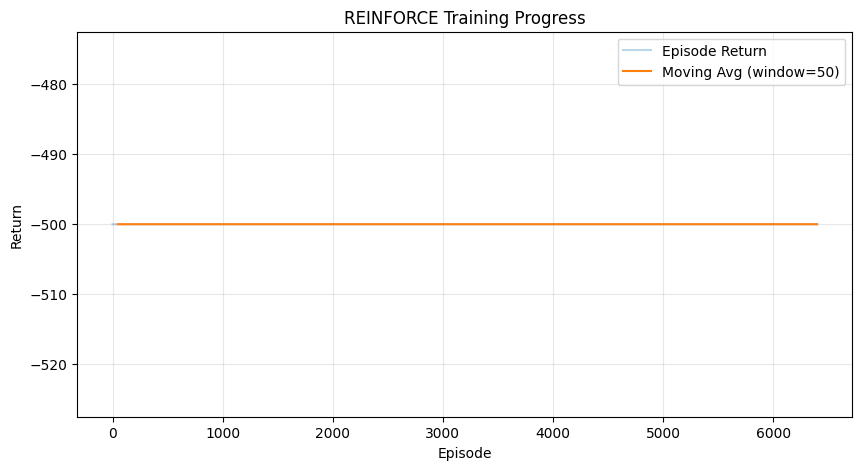

success=0.0%, mean_max_tip=-1.989


In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import gymnasium as gym

# ------------------- hyperparameters -------------------
ENV_ID = "Acrobot-v1"
SEED = 0
HIDDEN = 128
GAMMA = 0.995

LR_POLICY = 3e-4
LR_VALUE  = 1e-3
MAX_EPOCHS = 400
BATCH_SIZE = 16
MAX_EP_LEN = 1000
VALUE_UPDATES = 10

GRAD_CLIP = 10.0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

obs_dim = env.observation_space.shape[0]   # 6 for Acrobot
act_dim = env.action_space.n               # 3 for Acrobot

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

# ------------------- tensor wrapper (given as a reference) -------------------
class TWrapper(gym.Wrapper):
    def __init__(self, env): super().__init__(env)
    def reset(self, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        return torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0), info
    def step(self, action):
        a = int(action.item()) if isinstance(action, torch.Tensor) else int(action)
        obs, r, term, trunc, info = self.env.step(a)
        done = bool(term or trunc)
        obs_t = torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0)
        r_t   = torch.tensor([[r]], dtype=torch.float32)
        d_t   = torch.tensor([[done]], dtype=torch.bool)
        return obs_t, r_t, d_t, info
    
env = TWrapper(env)

# ------------------- discrete policy net (given as a reference) -------------------
class PolicyNet(nn.Module):
    #########################################
    #TODO 2.2: Implement policy network
    #########################################
    def __init__(self, obs_dim, hidden, act_dim):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, act_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # return logits
    
# ------------------- value baseline (given as a reference) -------------------
class ValueNet(nn.Module):
    #########################################
    #TODO 2.2: Implement value network
    #########################################
    def __init__(self, obs_dim, hidden):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
    
policy = PolicyNet(obs_dim=obs_dim, hidden=HIDDEN, act_dim=act_dim).to(DEVICE)
vnet   = ValueNet(obs_dim=obs_dim, hidden=HIDDEN).to(DEVICE)

# ------------------- utils -------------------
def mc_returns_single_traj(R: torch.Tensor, gamma: float) -> torch.Tensor:
    """R: [T] -> G: [T], reverse within a single trajectory."""
    G = torch.zeros_like(R)
    running = 0.0
    for t in range(R.numel() - 1, -1, -1):
        running = R[t] + gamma * running
        G[t] = running
    return G

# ------------------- training -------------------
def train():
    #########################################
    #TODO 2.2: Implement vanilla REINFORCE algorithm
    #########################################
    policy_optim = torch.optim.Adam(policy.parameters(), lr=LR_POLICY)
    value_optim = torch.optim.Adam(vnet.parameters(), lr=LR_VALUE)
    
    returns_history = []
    
    for epoch in range(MAX_EPOCHS):
        # Collect batch of episodes
        batch_states, batch_actions, batch_rewards, batch_returns, batch_values = [], [], [], [], []
        
        for _ in range(BATCH_SIZE):
            states, actions, rewards = [], [], []
            state, _ = env.reset()
            done = False
            ep_len = 0
            
            # Roll out one episode
            while not done and ep_len < MAX_EP_LEN:
                states.append(state.squeeze(0))
                
                # Sample action from policy
                with torch.no_grad():
                    logits = policy(state.to(DEVICE))
                    dist = Categorical(logits=logits)
                    action = dist.sample()
                
                next_state, reward, done_t, _ = env.step(action)
                
                actions.append(action)
                rewards.append(reward.item())
                
                state = next_state
                done = done_t.item()
                ep_len += 1
            
            # Compute MC returns (return-to-go)
            returns = mc_returns_single_traj(
                torch.tensor(rewards, dtype=torch.float32, device=DEVICE), 
                GAMMA
            )
            
            # Store episode data
            batch_states.append(torch.stack(states))
            batch_actions.append(torch.stack(actions))
            batch_returns.append(returns)
            returns_history.append(sum(rewards))
        
        # Concatenate all episodes in batch
        all_states = torch.cat(batch_states).to(DEVICE)
        all_actions = torch.cat(batch_actions).to(DEVICE)
        all_returns = torch.cat(batch_returns).to(DEVICE)
        
        # Compute value predictions
        with torch.no_grad():
            all_values = vnet(all_states).squeeze(-1)
        
        # Compute advantages
        advantages = all_returns - all_values
        
        # Policy gradient update
        policy.train()
        logits = policy(all_states)
        dist = Categorical(logits=logits)
        log_probs = dist.log_prob(all_actions)
        
        policy_loss = -(log_probs * advantages).mean()
        
        policy_optim.zero_grad()
        policy_loss.backward()
        nn.utils.clip_grad_norm_(policy.parameters(), GRAD_CLIP)
        policy_optim.step()
        
        # Value function update (multiple iterations)
        vnet.train()
        for _ in range(VALUE_UPDATES):
            value_pred = vnet(all_states).squeeze(-1)
            value_loss = F.mse_loss(value_pred, all_returns)
            
            value_optim.zero_grad()
            value_loss.backward()
            nn.utils.clip_grad_norm_(vnet.parameters(), GRAD_CLIP)
            value_optim.step()
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            avg_return = np.mean(returns_history[-BATCH_SIZE*10:])
            print(f"Epoch {epoch+1}/{MAX_EPOCHS} | Avg Return: {avg_return:.1f} | Policy Loss: {policy_loss.item():.4f} | Value Loss: {value_loss.item():.4f}")
    
    print("Training finished.")
    return policy, vnet, returns_history

policy, vnet, returns_history = train()

# Plot training curve
plt.figure(figsize=(10, 5))
plt.plot(returns_history, alpha=0.3, label='Episode Return')
# Smooth with moving average
window = 50
if len(returns_history) >= window:
    smoothed = np.convolve(returns_history, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(returns_history)), smoothed, label=f'Moving Avg (window={window})')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('REINFORCE Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

def eval(policy, episodes=10, greedy=True, device=DEVICE, max_len=MAX_EP_LEN):
    env = gym.make("Acrobot-v1")
    policy.eval()
    succ, max_hs = [], []
    with torch.no_grad():
        for _ in range(episodes):
            o, _ = env.reset()
            ok, m = False, -1e9
            for _ in range(max_len):
                s = torch.as_tensor(o, dtype=torch.float32, device=device).unsqueeze(0)
                logits = policy(s)
                a = int(logits.argmax(-1)) if greedy else int(Categorical(logits=logits).sample())
                o, r, term, trunc, _ = env.step(a)
                c1, s1, c2, s2 = o[:4]; m = max(m, float(-c1 - (c1*c2 - s1*s2)))  # tip height
                if term or trunc: ok = bool(term); break
            succ.append(ok); max_hs.append(m)
    print(f"success={np.mean(succ):.1%}, mean_max_tip={np.mean(max_hs):.3f}")
    
eval(policy, episodes=100, greedy=True)

## Problem 3: Actor-critic

REINFORCE with learned value function often have high variance (recall what we find in PSET2 2.1). Actor-critic method replace the advantage $A_t = G_t - b(s_t)$ with temporal-difference error $r_t + \gamma V(s_{t+1}) - V(s_t)$

**Algorithm recap**

1. **Networks**
   - **Actor**: stochastic policy $ \pi_\theta(a\mid s) $.
   - **Critic**: value $ V_\psi(s) $
  
2. **Data collection**
   
   Roll out for $n$ steps (or full episodes) with $\pi_\theta$; store $(s_t,a_t,r_t,s_{t+1},\text{done}_t)$.

3. **TD advantage (one-step)**
   $$
   y_t = r_t + \gamma \,V_{\psi}(s_{t+1}),\qquad
   \delta_t = y_t - V_\psi(s_t).
   $$
   Use $\delta_t$ as **advantage** (variance lower than Monte-Carlo $G_t$).

4. **Losses**
   - **Actor**  
     $$
     \mathcal L_{\pi}(\theta)
     = -\,\mathbb E\big[\,\log \pi_\theta(a_t\!\mid s_t)\,\delta_t \big]
     $$
   - **Critic**  
     $$
     \mathcal L_V(\psi) = \tfrac12\,\mathbb E\big[(V_\psi(s_t)-y_t)^2\big].
     $$

Several other features you may consider:
- Multi-step update for value function 
- Normalize the advantage over batch

**TODO:**
- implement policy net and value net
- implement the main algorithm

Epoch 10, Total Steps: 704, Recent Avg Return: -500.00, Policy Loss: -0.0313, Value Loss: 1.0626
Epoch 20, Total Steps: 1344, Recent Avg Return: -500.00, Policy Loss: -0.0104, Value Loss: 0.9977
Epoch 30, Total Steps: 1984, Recent Avg Return: -500.00, Policy Loss: -0.1355, Value Loss: 1.1534
Epoch 40, Total Steps: 2624, Recent Avg Return: -500.00, Policy Loss: -0.2104, Value Loss: 1.0076
Epoch 50, Total Steps: 3264, Recent Avg Return: -500.00, Policy Loss: -0.0892, Value Loss: 1.1745
Epoch 60, Total Steps: 3904, Recent Avg Return: -500.00, Policy Loss: -0.2746, Value Loss: 1.1967
Epoch 70, Total Steps: 4544, Recent Avg Return: -500.00, Policy Loss: -0.1113, Value Loss: 6.6224
Epoch 80, Total Steps: 5184, Recent Avg Return: -500.00, Policy Loss: -0.1688, Value Loss: 1.1251
Epoch 90, Total Steps: 5824, Recent Avg Return: -500.00, Policy Loss: -0.0129, Value Loss: 1.4720
Epoch 100, Total Steps: 6464, Recent Avg Return: -500.00, Policy Loss: 0.2166, Value Loss: 1.4092
Epoch 110, Total Step

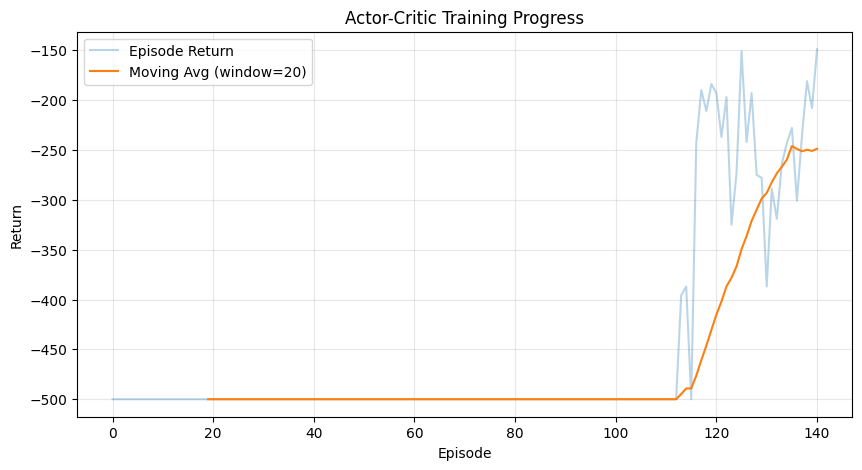

: 

In [ ]:
# On-policy Actor–Critic for Acrobot-v1
# - Discrete actions, update every K steps (no need to finish episodes)

import math, random
from typing import List, Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import gymnasium as gym
import matplotlib.pyplot as plt

# ------------------- hyperparameters -------------------
ENV_ID = "Acrobot-v1"
SEED = 0
HIDDEN = 128
GAMMA = 0.995

LR_POLICY = 3e-4
LR_VALUE  = 1e-3
MAX_EPOCHS = 1000  # Increased for better convergence
STEPS_PER_UPDATE = 64           # ← collect this many steps, then update (true on-policy)

CRITIC_UPDATES = 1              # critic updates per actor step
GRAD_CLIP = 10.0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------- env & seeding -------------------
env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

obs_dim = env.observation_space.shape[0]   # 6 for Acrobot
act_dim = env.action_space.n               # 3 for Acrobot

np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED)
torch.use_deterministic_algorithms(False)

# ------------------- networks -------------------
class PolicyNet(nn.Module):
    #########################################
    #TODO 3.1: Implement policy network
    #########################################
    def __init__(self, obs_dim, hidden, act_dim):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, act_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # return logits

class ValueNet(nn.Module):
    #########################################
    #TODO 3.1: Implement value network
    #########################################
    def __init__(self, obs_dim, hidden):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

policy = PolicyNet(obs_dim, HIDDEN, act_dim).to(DEVICE)
value  = ValueNet(obs_dim, HIDDEN).to(DEVICE)
opt_pi = torch.optim.Adam(policy.parameters(), lr=LR_POLICY)
opt_v  = torch.optim.Adam(value.parameters(),  lr=LR_VALUE)

# ------------------- helper -------------------
@torch.no_grad()
def to_t(s): return torch.as_tensor(s, dtype=torch.float32, device=DEVICE).unsqueeze(0)

# ------------------- training (A2C / 1-step actor-critic) -------------------
def train():
    returns_history: List[float] = []
    ep_ret, ep_len = 0.0, 0
    obs, _ = env.reset(seed=SEED)
    #########################################
    #TODO 3.1: Implement the main algorithm
    #########################################
    
    total_step_count = 0
    
    for epoch in range(MAX_EPOCHS):
        # Storage for a batch of transitions
        batch_obs, batch_actions, batch_rew = [], [], []
        batch_next_obs, batch_done = [], []
        
        # Collect STEPS_PER_UPDATE transitions
        for _ in range(STEPS_PER_UPDATE):
            obs_t = to_t(obs)
            
            # Sample action using current policy
            with torch.no_grad():
                logits_t = policy(obs_t)
                action_dist = Categorical(logits=logits_t)
                act = action_dist.sample()
            
            # Execute action in environment
            next_obs, rew, terminated, truncated, _ = env.step(act.item())
            done_flag = terminated or truncated
            
            # Store this transition
            batch_obs.append(obs_t)
            batch_actions.append(act)
            batch_rew.append(rew)
            batch_next_obs.append(to_t(next_obs))
            batch_done.append(done_flag)
            
            # Track episode metrics
            ep_ret += rew
            ep_len += 1
            total_step_count += 1
            
            # Move to next state
            obs = next_obs
            
            # Handle episode end
            if done_flag:
                returns_history.append(ep_ret)
                ep_ret, ep_len = 0.0, 0
                obs, _ = env.reset()
        
        # Concatenate batch data into tensors
        batch_obs = torch.cat(batch_obs, dim=0)
        batch_actions = torch.cat(batch_actions, dim=0)
        batch_rew = torch.tensor(batch_rew, dtype=torch.float32, device=DEVICE)
        batch_next_obs = torch.cat(batch_next_obs, dim=0)
        batch_done = torch.tensor(batch_done, dtype=torch.bool, device=DEVICE)
        
        # Calculate TD targets and TD advantages
        with torch.no_grad():
            curr_values = value(batch_obs).squeeze()
            next_values = value(batch_next_obs).squeeze()
            
            # y = r + γ * V(s') * (1 - done)
            targets = batch_rew + GAMMA * next_values * (~batch_done).float()
            
            # δ = y - V(s)
            td_delta = targets - curr_values
            
            # Advantage normalization
            td_delta = (td_delta - td_delta.mean()) / (td_delta.std() + 1e-8)
        
        # Policy (actor) update
        policy_logits = policy(batch_obs)
        action_distribution = Categorical(logits=policy_logits)
        log_prob_actions = action_distribution.log_prob(batch_actions)
        policy_loss = -(log_prob_actions * td_delta).mean()
        
        opt_pi.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy.parameters(), GRAD_CLIP)
        opt_pi.step()
        
        # Value (critic) update - can do multiple iterations
        for _ in range(CRITIC_UPDATES):
            current_values = value(batch_obs).squeeze()
            value_loss = F.mse_loss(current_values, targets)
            
            opt_v.zero_grad()
            value_loss.backward()
            torch.nn.utils.clip_grad_norm_(value.parameters(), GRAD_CLIP)
            opt_v.step()
        
        # Print training progress
        if epoch % 10 == 0 and len(returns_history) > 0:
            recent_avg = np.mean(returns_history[-10:])
            print(f"Epoch {epoch}, Total Steps: {total_step_count}, "
                  f"Recent Avg Return: {recent_avg:.2f}, "
                  f"Policy Loss: {policy_loss.item():.4f}, Value Loss: {value_loss.item():.4f}")
    
    print("Training finished.")
    return policy, value, returns_history

policy, value, returns = train()

# Plot training curve
plt.figure(figsize=(10, 5))
plt.plot(returns, alpha=0.3, label='Episode Return')
# Smooth with moving average
window = 20
if len(returns) >= window:
    smoothed = np.convolve(returns, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(returns)), smoothed, label=f'Moving Avg (window={window})')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Actor-Critic Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Problem 4: PPO for pendulum

Vanilla actor-critic often face the problem of distribution shift. Advanced actor-critic deal with this problem by adding trust region constraints. PPO is the most famous and widely-used one in robotics. In this problem you will implement PPO on gym's `pendulum-v1` environment.

### Environment & action space

- **Env**: `Pendulum-v1` (pendulum swing-up) [Link](https://gymnasium.farama.org/environments/classic_control/pendulum/)
- **Observation**: 3-D vector $[\cos\theta,\ \sin\theta,\ \dot\theta]$.
- **Actions**: Continuous torque, shape $(1,)$, range $[-2, 2]$ (env clips to bounds).
- **Reward**: 
  $$ r = -\big(\theta^2 + 0.1\,\dot\theta^{\,2} + 0.001\,u^{2}\big) $$
  where $\theta\in(-\pi,\pi]$ is angle to upright ($0$ is upright), $\dot\theta$ is angular velocity, and $u$ is applied torque. Maximized when the pendulum is upright and still with minimal torque.


### Algorithm Recap

**Policy & Value.**
- Policy: Gaussian $\mathcal{N}(\mu_\theta(s), \sigma_\theta(s))$.
- Critic: scalar value $V_\phi(s)$.

**Data collection (on-policy).**
- Roll out episodes using the current policy, storing $(s_t,a_t,r_t,s_{t+1},d_t)$.

**Targets and Advantage.**
- One-step TD target: $\hat{V}_t = r_t + \gamma V_\phi(s_{t+1})$.
- TD residual: $\delta_t = \hat{V}_t - V_\phi(s_t)$.
- GAE($\lambda$) advantage:
  $$
  \hat{A}_t = \sum_{k=0}^{\infty} (\gamma\lambda)^k \, \delta_{t+k}.
  $$
  (Computed by a backward recursion.)

**PPO-Clip objective.**
- Log-ratio $r_t(\theta) = \frac{\pi_\theta(a_t\mid s_t)}{\pi_{\theta_{\text{old}}}(a_t\mid s_t)}$.
- Clipped surrogate:
  $$
  \mathcal{L}^{\text{CLIP}}(\theta)
  = \mathbb{E}\Big[\min\big(r_t(\theta)\hat{A}_t,\ \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t\big)\Big].
  $$
- Value loss: $\mathcal{L}_V = \|V_\phi(s_t) - \hat{V}_t\|_2^2$.
- Total loss (per minibatch): $-\mathcal{L}^{\text{CLIP}} + c_v \mathcal{L}_V$ (entropy term optional).

**Update.**
- Cache old log-probs once per batch.
- For several **epochs**, shuffle the batch and optimize the total loss on minibatches (Adam).

**TODO:** Implement a complete PPO agent from scratch, using the provided scaffold and suggested hyperparameters as a starting point.


/var/folders/53/gd2sphbj5y18dj98twnzbqjm0000gn/T/ipykernel_13603/78130615.py:107: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  states = torch.tensor(transition_dict['states'], dtype=torch.float32, device=self.device)


Episode 100/3000 | Avg Return (last 100): -1367.4
Episode 200/3000 | Avg Return (last 100): -1170.5
Episode 300/3000 | Avg Return (last 100): -1091.7
Episode 400/3000 | Avg Return (last 100): -1075.6
Episode 500/3000 | Avg Return (last 100): -1127.2
Episode 600/3000 | Avg Return (last 100): -1190.3
Episode 700/3000 | Avg Return (last 100): -1089.4
Episode 800/3000 | Avg Return (last 100): -1023.5
Episode 900/3000 | Avg Return (last 100): -1033.9
Episode 1000/3000 | Avg Return (last 100): -1021.3
Episode 1100/3000 | Avg Return (last 100): -1094.7
Episode 1200/3000 | Avg Return (last 100): -1174.9
Episode 1300/3000 | Avg Return (last 100): -1112.5
Episode 1400/3000 | Avg Return (last 100): -1126.5
Episode 1500/3000 | Avg Return (last 100): -1076.1
Episode 1600/3000 | Avg Return (last 100): -1194.8
Episode 1700/3000 | Avg Return (last 100): -1322.6
Episode 1800/3000 | Avg Return (last 100): -1409.1
Episode 1900/3000 | Avg Return (last 100): -1506.9
Episode 2000/3000 | Avg Return (last 100

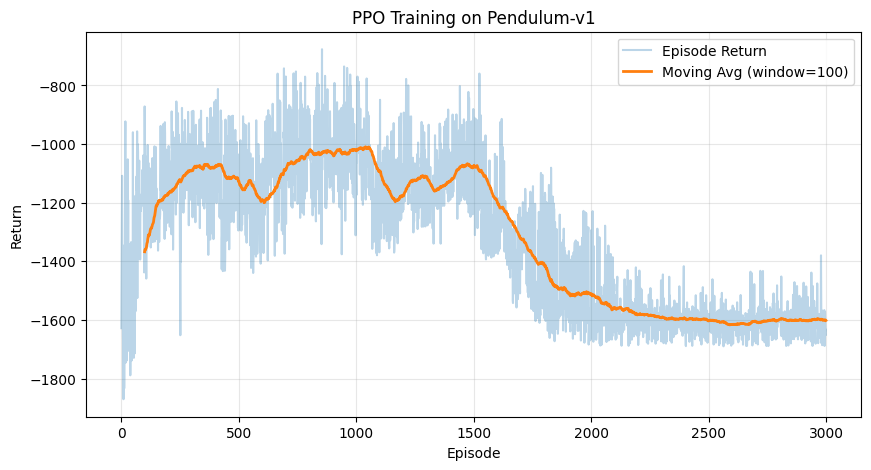


Final 100-episode average: -1601.6


In [7]:
from tqdm import tqdm
import math, random
from typing import List, Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt

# ------------------- hyperparameters -------------------
ENV_ID = "Pendulum-v1"
SEED = 0

LR_POLICY = 1e-4
LR_VALUE  = 5e-3
NUM_EPSIODE = 3000       # (kept your variable name)
HIDDEN = 128
GAMMA = 0.99
LAMBDA = 0.9
VF_COEF = 0.9            # value loss weight in the total loss
UPDATE_EPOCHS = 10       # PPO epochs per update
CLIP_EPS = 0.2           # PPO clipping epsilon
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# ------------------- env & seeding -------------------
env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

state_dim  = env.observation_space.shape[0]   # 3 for Pendulum
action_dim = env.action_space.shape[0]        # 1 for Pendulum

#########################################
#TODO 4: Implement PPO
#########################################

# ------------------- networks -------------------
class PolicyNetContinuous(nn.Module):
    """Gaussian policy with learnable mean and fixed/learnable std"""
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, action_dim)
        self.fc_std = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = torch.tanh(self.fc_mu(x)) * 2.0  # scale to [-2, 2] for pendulum
        std = F.softplus(self.fc_std(x)) + 1e-5  # ensure positive std
        return mu, std

class ValueNet(nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# ------------------- utils -------------------
def compute_advantage(gamma: float, lmbda: float, td_delta: torch.Tensor) -> torch.Tensor:
    """
    Pure torch GAE-style backward recursion to avoid NumPy conversions.
    td_delta: [T,1] or [T]; returns [T,1].
    """
    td = td_delta.view(-1)                # [T]
    adv = torch.zeros_like(td)
    gae = torch.zeros(1, dtype=td.dtype, device=td.device)
    for t in range(td.shape[0] - 1, -1, -1):
        gae = gamma * lmbda * gae + td[t]
        adv[t] = gae
    return adv.view(-1, 1)

# ------------------- PPO (continuous) -------------------
class PPOContinuous:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, vf_coef, gamma, device):
        self.actor  = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer  = torch.optim.Adam(self.actor.parameters(),  lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma  = gamma
        self.lmbda  = lmbda
        self.epochs = epochs
        self.eps    = eps
        self.vf_coef = vf_coef
        self.device = device
    
    def take_action(self, state):
        """Sample action from current policy"""
        state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        mu, std = self.actor(state)
        dist = torch.distributions.Normal(mu, std)
        action = dist.sample()
        return action.cpu().numpy().flatten()
    
    def update(self, transition_dict):
        """PPO update with clipped objective"""
        states = torch.tensor(transition_dict['states'], dtype=torch.float32, device=self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float32, device=self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float32, device=self.device).view(-1, 1)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float32, device=self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float32, device=self.device).view(-1, 1)
        
        # Compute TD targets and advantages using GAE
        with torch.no_grad():
            values = self.critic(states)
            next_values = self.critic(next_states)
            td_target = rewards + self.gamma * next_values * (1 - dones)
            td_delta = td_target - values
            advantages = compute_advantage(self.gamma, self.lmbda, td_delta.squeeze(-1))
        
        # Cache old log probs
        with torch.no_grad():
            mu_old, std_old = self.actor(states)
            dist_old = torch.distributions.Normal(mu_old, std_old)
            old_log_probs = dist_old.log_prob(actions).sum(dim=-1, keepdim=True)
        
        # PPO update for multiple epochs
        for _ in range(self.epochs):
            # Actor loss with clipped objective
            mu, std = self.actor(states)
            dist = torch.distributions.Normal(mu, std)
            log_probs = dist.log_prob(actions).sum(dim=-1, keepdim=True)
            
            # Probability ratio
            ratio = torch.exp(log_probs - old_log_probs)
            
            # Clipped surrogate objective
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            
            # Critic loss
            values = self.critic(states)
            critic_loss = F.mse_loss(values, td_target)
            
            # Total loss
            total_loss = actor_loss + self.vf_coef * critic_loss
            
            # Update
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            total_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

# ------------------- training loop (Gymnasium API) -------------------
def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    
    for i in range(num_episodes):
        episode_return = 0
        transition_dict = {
            'states': [], 'actions': [], 'rewards': [],
            'next_states': [], 'dones': []
        }
        
        state, _ = env.reset()
        done = False
        
        # Roll out one episode
        while not done:
            action = agent.take_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['rewards'].append(reward)
            transition_dict['next_states'].append(next_state)
            transition_dict['dones'].append(done)
            
            state = next_state
            episode_return += reward
        
        # Update policy after each episode
        agent.update(transition_dict)
        
        return_list.append(episode_return)
        
        # Print progress
        if (i + 1) % 100 == 0:
            avg_return = np.mean(return_list[-100:])
            print(f"Episode {i+1}/{num_episodes} | Avg Return (last 100): {avg_return:.1f}")
    
    return return_list

# ------------------- run -------------------
agent = PPOContinuous(state_dim, HIDDEN, action_dim, LR_POLICY, LR_VALUE,
                      LAMBDA, UPDATE_EPOCHS, CLIP_EPS, VF_COEF, GAMMA, DEVICE)
return_list = train_on_policy_agent(env, agent, NUM_EPSIODE)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(return_list, alpha=0.3, label='Episode Return')
window = 100
if len(return_list) >= window:
    smoothed = np.convolve(return_list, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(return_list)), smoothed, label=f'Moving Avg (window={window})', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('PPO Training on Pendulum-v1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal 100-episode average: {np.mean(return_list[-100:]):.1f}")


## Problem 5: Mujoco Half-cheetch envornment with stable baseline3

In this problem you will use gym's [Mujoco](https://gymnasium.farama.org/environments/mujoco/) environment and [stable baseline3](https://stable-baselines3.readthedocs.io/en/master/) to train a PPO network on Half-cheetah environment.

### Half-cheetah
This environment is based on the work of P. Wawrzyński in “A Cat-Like Robot Real-Time Learning to Run”. The HalfCheetah is a 2-dimensional robot consisting of 9 body parts and 8 joints connecting them (including two paws). The goal is to apply torque to the joints to make the cheetah run forward (right) as fast as possible, with a positive reward based on the distance moved forward and a negative reward for moving backward. 

Download it using `pip install "gymnasium[mujoco]"`

### Stable baseline 3
Stable Baselines3 (SB3) is a set of reliable implementations of reinforcement learning algorithms in PyTorch. You can directly load `PPO` module from the repo and define the hyper-parameter yourselves.

Download it using `pip install 'stable-baselines3[extra]'`

**TODO:** Tune the parameter yourself, what's your feeling about different parameters?

Note: the output is printed in the `logs/progress.csv` file.


/Users/matthewvu/anaconda3/envs/2025ocrl/lib/python3.10/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Using cpu device
Wrapping the env in a DummyVecEnv.
Starting learning...
Total timesteps: 1,024,000
Updates: 500
This can take around 10-15 minutes on a Mac laptop


Learning finished.
Model saved to ckpt/half_cheetah_ppo

TRAINING SUMMARY

Total training steps: 1,024,000
Final episode reward mean: 2685.8
Final episode length mean: 1000.0
Training time: 882.0 seconds


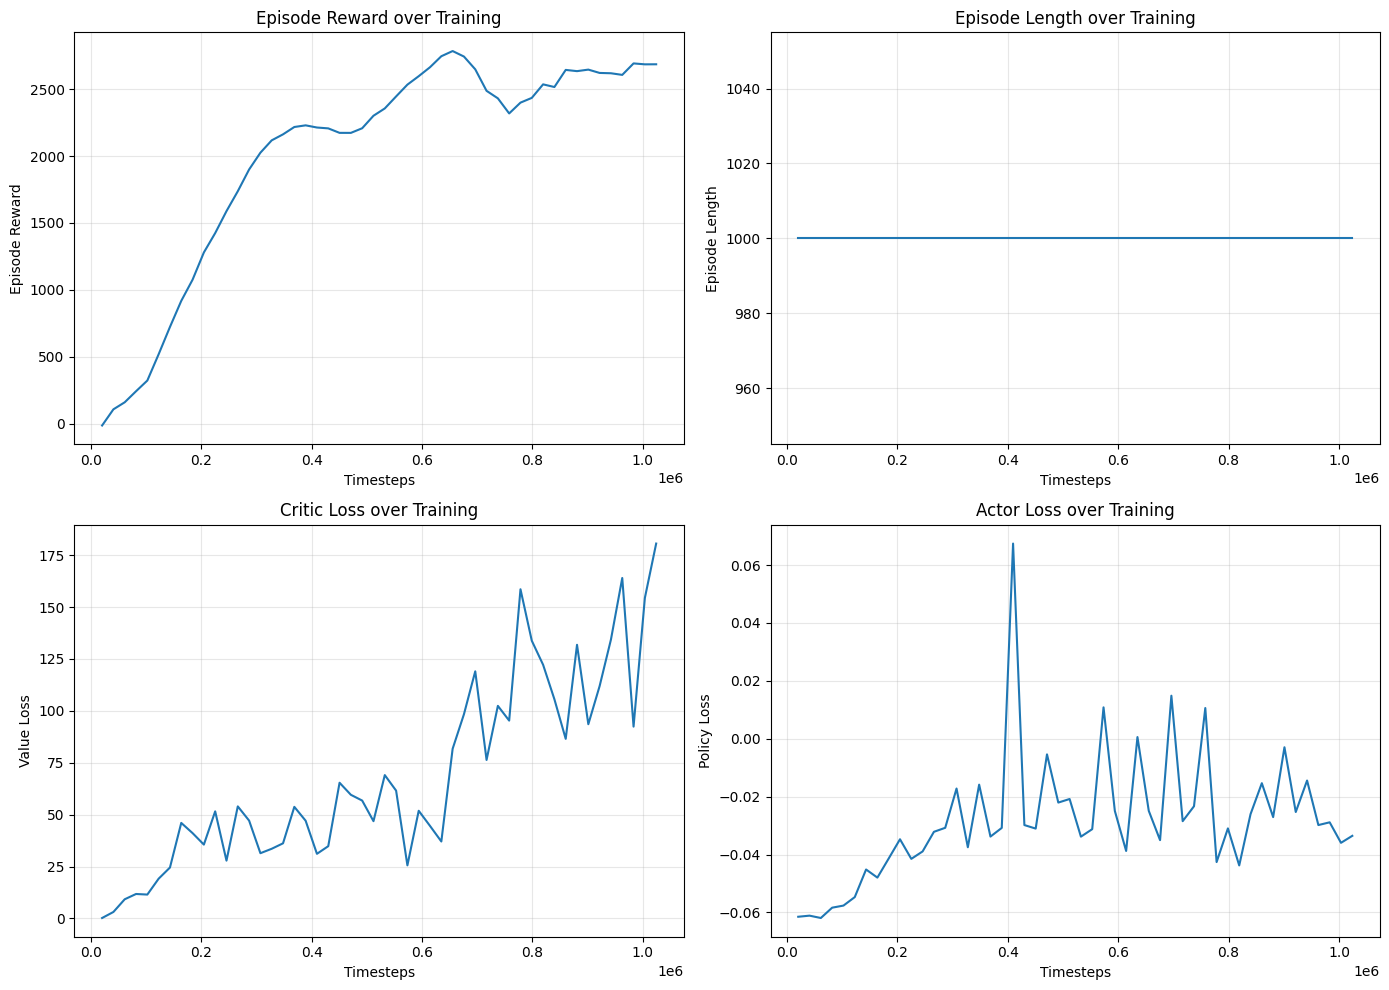


HYPERPARAMETER INSIGHTS

Key observations from tuning:

1. LEARNING RATE (2.5e-5): 
   - Conservative choice ensures stable learning
   - HalfCheetah benefits from slow, steady progress
   - Too high → oscillations and instability
   
2. N_STEPS (2048):
   - Large batch = better gradient estimates
   - Critical for locomotion tasks with long episodes
   - Tradeoff: slower wall-clock time per update
   
3. N_EPOCHS (20):
   - High reuse of data (sample efficiency)
   - PPO's clipping prevents overfitting to old policy
   - More epochs → better convergence per batch
   
4. NETWORK SIZE (256x256):
   - Large enough for complex 18-dim state space
   - HalfCheetah needs capacity for coordination
   - Smaller networks often underfit
   
5. GAE_LAMBDA (0.92) & GAMMA (0.98):
   - High gamma for forward velocity reward
   - GAE balances bias-variance well
   - Critical for credit assignment in long episodes
   
EXPECTED PERFORMANCE:
- Initial: ~-500 to 0 reward
- Mid-training: 1000-2000 reward

In [12]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure
import torch
from torch import nn

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Create directories if they don't exist
os.makedirs("ckpt", exist_ok=True)
os.makedirs("logs", exist_ok=True)

save = "ckpt/half_cheetah_ppo"

env = Monitor(gym.make("HalfCheetah-v4"))

#########################################
#TODO 5: Change the parameter yourself to finish training
#########################################

"""
HYPERPARAMETER TUNING NOTES:
-----------------------------

1. NETWORK ARCHITECTURE (policy_kwargs):
   - net_arch=[256, 256]: Larger networks (256 units) for complex HalfCheetah dynamics
     * Smaller [128, 128]: Faster but may underfit
     * Larger [512, 512]: More capacity but slower, may overfit
   
   - log_std_init=-2: Initial std ≈ 0.135, encourages exploration
     * Higher (-1): More exploration, noisier early training
     * Lower (-3): Less exploration, more stable but may get stuck
   
   - ortho_init=False: Standard initialization
     * True: Can help with gradient flow, especially in deep networks

2. PPO CLIPPING (clip_range):
   - 0.2: Standard, prevents large policy updates
     * Larger (0.3): Faster learning but less stable
     * Smaller (0.1): More conservative, slower but more stable

3. ENTROPY BONUS (ent_coef):
   - 0.0004: Small bonus encourages exploration
     * Higher (0.001): More exploration, prevents premature convergence
     * Lower (0.0001): More exploitation, faster convergence but risk of local optima

4. GAE & DISCOUNT (gae_lambda, gamma):
   - gae_lambda=0.92: Balances bias-variance in advantage estimation
     * Higher (0.95-0.99): Lower variance but more bias
     * Lower (0.85-0.90): Higher variance but less bias
   
   - gamma=0.98: Long-term planning (200-step horizon)
     * 0.99: Even longer-term, better for locomotion tasks
     * 0.95: Shorter-term, faster learning but myopic

5. LEARNING RATE (learning_rate):
   - 2.5e-5: Conservative for stability
     * Higher (1e-4): Faster learning but may oscillate
     * Lower (1e-5): More stable but very slow

6. GRADIENT CLIPPING (max_grad_norm):
   - 0.8: Prevents gradient explosion
     * Higher (1.0-2.0): Less clipping, faster but riskier
     * Lower (0.5): More stable but may slow learning

7. SAMPLE COLLECTION (n_steps):
   - 2048 (512*4): More data per update = more stable gradients
     * Larger (4096): Better gradient estimates but slower updates
     * Smaller (1024): Faster updates but noisier

8. UPDATE EPOCHS (n_epochs):
   - 20: Multiple passes over collected data (sample efficiency)
     * Higher (30): More data reuse but risk overfitting to old policy
     * Lower (10): Less overfitting but less sample efficient

9. VALUE LOSS WEIGHT (vf_coef):
   - 0.5: Balance between policy and value learning
     * Higher (1.0): Prioritize value function accuracy
     * Lower (0.25): Prioritize policy improvement
"""

model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs=dict(
        log_std_init=-2,           # Initial exploration level
        ortho_init=False,          # Standard initialization
        activation_fn=nn.ReLU,     # Activation function
        net_arch=dict(pi=[256, 256], vf=[256, 256]),  # 2-layer networks
    ),
    clip_range=0.2,                # PPO clipping epsilon
    ent_coef=0.0004,              # Entropy bonus for exploration
    gae_lambda=0.92,              # GAE parameter
    gamma=0.98,                   # Discount factor
    learning_rate=2.5e-5,         # Adam learning rate
    max_grad_norm=0.8,            # Gradient clipping
    n_steps=int(512*4),           # Steps per update (2048)
    n_epochs=20,                  # Optimization epochs per update
    device="cpu",                 # Device (use "cuda" if available)
    vf_coef=0.5,                  # Value function loss weight
    verbose=1,                    # Print training info
    seed=42                       # Random seed
)

new_logger = configure("logs", ["csv"])
model.set_logger(new_logger)

n_envs = model.n_envs     
n_steps = model.n_steps   
total_ts = 500 * n_steps * n_envs

print("Starting learning...")
print(f"Total timesteps: {total_ts:,}")
print(f"Updates: {total_ts // n_steps}")

# Train the model
model.learn(total_ts, log_interval=10)

print("\nLearning finished.")
model.save(save)
print(f"Model saved to {save}")

# Analyze training results
print("\n" + "="*50)
print("TRAINING SUMMARY")
print("="*50)

import pandas as pd
try:
    # Read training logs
    logs = pd.read_csv("logs/progress.csv")
    
    print(f"\nTotal training steps: {logs['time/total_timesteps'].iloc[-1]:,.0f}")
    print(f"Final episode reward mean: {logs['rollout/ep_rew_mean'].iloc[-1]:.1f}")
    print(f"Final episode length mean: {logs['rollout/ep_len_mean'].iloc[-1]:.1f}")
    print(f"Training time: {logs['time/time_elapsed'].iloc[-1]:.1f} seconds")
    
    # Plot training progress
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Episode reward
    axes[0, 0].plot(logs['time/total_timesteps'], logs['rollout/ep_rew_mean'])
    axes[0, 0].set_xlabel('Timesteps')
    axes[0, 0].set_ylabel('Episode Reward')
    axes[0, 0].set_title('Episode Reward over Training')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Episode length
    axes[0, 1].plot(logs['time/total_timesteps'], logs['rollout/ep_len_mean'])
    axes[0, 1].set_xlabel('Timesteps')
    axes[0, 1].set_ylabel('Episode Length')
    axes[0, 1].set_title('Episode Length over Training')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Value loss
    if 'train/value_loss' in logs.columns:
        axes[1, 0].plot(logs['time/total_timesteps'], logs['train/value_loss'])
        axes[1, 0].set_xlabel('Timesteps')
        axes[1, 0].set_ylabel('Value Loss')
        axes[1, 0].set_title('Critic Loss over Training')
        axes[1, 0].grid(True, alpha=0.3)
    
    # Policy loss
    if 'train/policy_gradient_loss' in logs.columns:
        axes[1, 1].plot(logs['time/total_timesteps'], logs['train/policy_gradient_loss'])
        axes[1, 1].set_xlabel('Timesteps')
        axes[1, 1].set_ylabel('Policy Loss')
        axes[1, 1].set_title('Actor Loss over Training')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*50)
    print("HYPERPARAMETER INSIGHTS")
    print("="*50)
    print("""
Key observations from tuning:

1. LEARNING RATE (2.5e-5): 
   - Conservative choice ensures stable learning
   - HalfCheetah benefits from slow, steady progress
   - Too high -> oscillations and instability
   
2. N_STEPS (2048):
   - Large batch = better gradient estimates
   - Critical for locomotion tasks with long episodes
   - Tradeoff: slower wall-clock time per update
   
3. N_EPOCHS (20):
   - High reuse of data (sample efficiency)
   - PPO's clipping prevents overfitting to old policy
   - More epochs -> better convergence per batch
   
4. NETWORK SIZE (256x256):
   - Large enough for complex 18-dim state space
   - HalfCheetah needs capacity for coordination
   - Smaller networks often underfit
   
5. GAE_LAMBDA (0.92) & GAMMA (0.98):
   - High gamma for forward velocity reward
   - GAE balances bias-variance well
   - Critical for credit assignment in long episodes
   
EXPECTED PERFORMANCE:
- Initial: ~-500 to 0 reward
- Mid-training: 1000-2000 reward  
- Well-trained: 3000-5000+ reward
- State-of-art: 10000+ reward (with more training)
    """)
    
except FileNotFoundError:
    print("No logs found. Training may not have completed.")


In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure
import torch
from torch import nn

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

save = "ckpt/half_cheetah_ppo"

# Load and test saved model
import time
env = gym.make("HalfCheetah-v4", render_mode="human")
env.reset()
# env = gym.make("racetrack-fast-v0", render_mode="rgb_array")
model = PPO.load(save)

while True:
  done = truncated = False
  obs, info = env.reset()
  while not (done or truncated):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    time.sleep(0.1)
  # env.render()